In [1]:
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile
import soundfile as sf
import os
from os.path import basename
import cv2
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import IPython.display as ipd
import gc
%matplotlib inline

import pickle
import tempfile
import time
import math
import keras
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.utils.data_utils import Sequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

from utils import *

seed = 0
np.random.seed(seed)
import random
random.seed(seed)

Using TensorFlow backend.
/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [19]:
def readPaths(data_folder_path, val_split = 0.2):
    """
    Return consolidated and preprocessed wav file melspectograms and labels 
    imported from the provided locations 
    
    Arguments:
    data_folder_path  -- Path of folder containing training audio folders
    audio_length      -- Length of output audio (milliseconds)
    """
    
    # Get list of speakers for train-val split
    speakers = []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
        if label=='_background_noise_':
            continue
        speakers.append(file_[file_.rfind('/')+1:file_.find('_')])
    
    # Split into training and validation
    train_speakers, val_speakers = train_test_split(list(set(speakers)), test_size=val_split, random_state=42)
    
    label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
    
    tr_num, val_num = 0, 0
    val_paths, train_paths = [], []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
        if label=='_background_noise_':
            val_paths+=[file_]*66
            train_paths+=[file_]*300
            continue
        if label not in label_list[:-2]+['silence']:
            unknown_label = label
            label = 'unknown'
        
        speaker = file_[file_.rfind('/')+1:file_.find('_')]
        
        if (speaker in val_speakers and label != 'unknown') or (label == 'unknown' and 
                                                                speaker in val_speakers and
                                                                unknown_label in ['house', 'dog', 'two', 'five']):
            val_paths.append(file_)
        elif (speaker in train_speakers and label != 'unknown') or (label == 'unknown' and
                                                                    speaker in train_speakers and
                                                                    unknown_label not in ['house', 'dog', 'two', 'five']):
            train_paths.append(file_)
    
    random.shuffle(train_paths)
    random.shuffle(val_paths)
    return [train_paths, val_paths]

In [ ]:
paths = readPaths('./Data/train/audio/')

In [2]:
paths = pickle.load(open('./Data/train_val_paths.pickle', 'rb'))

In [3]:
data = pickle.load(open('./Data/train_val_balanced.pickle', 'rb'))

In [12]:
def moreData():
    label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
    x_batch = []
    y_batch = []
    for idx, file_ in enumerate(paths[1]):
        label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
        if label=='_background_noise_':
            label = 'silence'
        if label not in label_list[:-2]+['silence']:
            unknown_label = label
            label = 'unknown'
            if np.random.choice([True, False], p=[0.7, 0.3]):
                continue
        speaker = file_[file_.rfind('/')+1:file_.find('_')]

        if label == 'silence':
            sil_len = np.random.randint(70, 91)
            start_ = np.random.choice((np.arange(16000*60-sil_len*200)))
            X, sr = sf.read(file_, start=start_, stop=start_+sil_len*200)
        else:
            X, sr = sf.read(file_)
            X, _ = librosa.effects.trim(X)
#         if label == 'unknown':
#             X = randomMix(X, sr, speaker, unknown_label, u=1.0)
#         if label != 'silence':
#             X = randomNoise(X, sr, bg_wavs, u=1.0)
#             X = randomSpeed(X, sr, u=1.0)            
#         if X.shape[0]>18500:
#             print(X.shape, file_)

        # For smaller length - equal padding on both sides
        if len(X)<80*200:
            len_req = 80*200-len(X)
            X = np.concatenate((np.zeros((len_req//2)), X, np.zeros((len_req - (len_req//2)))))
        # For bigger lengths - use the middle section
        start_ = (len(X) - (80*200))//2
        X = X[start_:start_+80*200-1]
        
        file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sr, n_mels=128,
                                                                          hop_length=200), ref=np.max)
#         file_feature2 = librosa.feature.mfcc(X, sr, n_mfcc=128, hop_length=370)
#         file_feature = cv2.resize(librosa.power_to_db(file_feature, ref=np.max), (45, 128))
#         file_feature2 = cv2.resize(file_feature2, (45, 128))
#         file_feature = np.stack((file_feature, file_feature2), axis=2)

        label_np = np.zeros((12))
        label_np[label_list.index(label)] = 1.0
        x_batch.append(file_feature.reshape((128, 80, 1)))
        y_batch.append(label_np)
    
        if idx%5000==0:
            print(idx, file_, label)
    return np.array(x_batch), np.array(y_batch)


In [63]:
def moreData():
    label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
    ternary_labels = ['known', 'unknown', 'silence']
    x_batch = []
    y_batch = []
    for idx, file_ in enumerate(paths[1]):
        label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
        if label=='_background_noise_':
            label = 'silence'
        if label not in label_list[:-2]+['silence']:
            unknown_label = label
            label = 'unknown'
            if np.random.choice([True, False], p=[0.5, 0.5]):
                continue
        speaker = file_[file_.rfind('/')+1:file_.find('_')]

        if label == 'silence':
            start_ = np.random.choice((np.arange(16000*60-50*370)))
            X, sr = sf.read(file_, start=start_, stop=start_+50*370)
        else:
            X, sr = sf.read(file_)
            X, _ = librosa.effects.trim(X)
#         if label == 'unknown':
#             X = randomMix(X, sr, speaker, unknown_label, u=1.0)
#         if label != 'silence':
#             X = randomNoise(X, sr, bg_wavs, u=1.0)
#             X = randomSpeed(X, sr, u=1.0)            
        if X.shape[0]>18500:
            print(X.shape, file_)
        if len(X)<50*370:
                X = np.concatenate((X, np.zeros((50*370-len(X)-1))))
        X = X[:50*370-1]
        file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sr, n_mels=128, 
                                                                          hop_length=370), ref=np.max)
#         file_feature2 = librosa.feature.mfcc(X, sr, n_mfcc=128, hop_length=370)
#         file_feature = cv2.resize(librosa.power_to_db(file_feature, ref=np.max), (45, 128))
#         file_feature2 = cv2.resize(file_feature2, (45, 128))
#         file_feature = np.stack((file_feature, file_feature2), axis=2)
        
        if label in label_list[:-2]:
            label = 'known'
        label_np = np.zeros((3))
        label_np[ternary_labels.index(label)] = 1.0
        x_batch.append(file_feature.reshape((128, 50, 1)))
        y_batch.append(label_np)
    
        if idx%5000==0:
            print(idx, file_, label)
    return np.array(x_batch), np.array(y_batch)


In [13]:
val_data = moreData()

0 ./Data/train/audio/off/1bb6ed89_nohash_0.wav off
5000 ./Data/train/audio/two/cb8f8307_nohash_2.wav unknown


In [14]:
# pickle.dump(val_data, open('./Data/val_data_balanced.pickle', 'wb'))

In [3]:
val_data = pickle.load(open('./Data/val_data_balanced.pickle', 'rb'))

In [35]:
val_data_prev = pickle.load(open('./Data/train_val_balanced.pickle', 'rb'))

#### Generator Functions

In [15]:
labels = []
label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
for file_ in paths[0]:
    label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
    if label=='_background_noise_':
        label = 'silence'
    if label not in label_list[:-2]+['silence']:
        unknown_label = label
        label = 'unknown'
    label_np = np.zeros((12))
    label_np[label_list.index(label)] = 1.0
    labels.append(label_np)

In [16]:
unknown_idx = np.where(np.argmax(np.array(labels), 1)==10)[0]

In [17]:
bg_files = ['pink_noise.wav', 'dude_miaowing.wav', 'exercise_bike.wav',
                    'doing_the_dishes.wav', 'white_noise.wav', 'running_tap.wav']
bg_wavs = {file_ : sf.read('./Data/train/audio/_background_noise_/'+file_)[0] for file_ in bg_files}

In [18]:
class train_generator(Sequence):

    def __init__(self):
        self.ids_train_split = paths[0]
        self.unknown_idx = unknown_idx 
        self.batch_size = batch_size
        self.audio_length = 80
        self.n_mels = 128
        self.label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']

    def __len__(self):
        return 22946 // self.batch_size

    def __getitem__(self, idx):
        dropped_idx = np.random.choice(self.unknown_idx, size=31096)
        ids_train_split_balanced = [val for i, val in enumerate(self.ids_train_split) if i not in dropped_idx]
        ids_train_batch = ids_train_split_balanced[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x_batch = []
        y_batch = []
        for file_ in ids_train_batch:
            label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
            if label=='_background_noise_':
                label = 'silence'
            if label not in self.label_list[:-2]+['silence']:
                unknown_label = label
                label = 'unknown'
            speaker = file_[file_.rfind('/')+1:file_.find('_')]
            
            if label == 'silence':
                sil_len = np.random.randint(self.audio_length-10, self.audio_length+11)
                start_ = np.random.choice((np.arange(16000*60-sil_len*200)))
                X, sr = sf.read(file_, start=start_, stop=start_+sil_len*200)
            else:
                X, sr = sf.read(file_)
                X, _ = librosa.effects.trim(X)
            if label == 'unknown':
                X = randomMix(X, sr, speaker, unknown_label, u=0.4)
            if label != 'silence':
                X = randomVol(X, u=0.3)
                X = randomNoise(X, sr, bg_wavs, u=0.3)
                X = randomSpeed(X, sr, u=0.3)
            
            # For smaller length - equal padding on both sides
            if len(X)<self.audio_length*200:
                len_req = self.audio_length*200-len(X)
                X = np.concatenate((np.zeros((len_req//2)), X, np.zeros((len_req - (len_req//2)))))
            # For bigger lengths - use the middle section
            start_ = (len(X) - (self.audio_length*200))//2
            X = X[start_:start_+self.audio_length*200-1]
        
            file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sr, 
                                                                              n_mels=self.n_mels, hop_length=200), 
                                               ref=np.max)
#             file_feature2 = librosa.feature.mfcc(X, sr, n_mfcc=self.n_mels, hop_length=370)
#             file_feature = cv2.resize(file_feature, (self.audio_length, self.n_mels))
#             file_feature2 = cv2.resize(file_feature2, (self.audio_length, self.n_mels))
#             file_feature = np.stack((file_feature, file_feature2), axis=2)
            
            label_np = np.zeros((12))
            label_np[self.label_list.index(label)] = 1.0
            x_batch.append(file_feature.reshape((self.n_mels, self.audio_length, 1)))
            y_batch.append(label_np)
            
        return np.array(x_batch), np.array(y_batch)
    
    def on_epoch_end(self):
        pass

#### Train Model

In [2]:
#Create model - (Convolution layers --> Max Pooling layer) x3 --> Fully connected layer --> Dropout layer --> Readout layer
model=Sequential()

model.add(Conv2D(15, (3, 3),input_shape=(128, 80, 1), padding="same", kernel_initializer='glorot_uniform'))
model.add(Conv2D(15, (3, 3),padding="same", kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(45, (2, 2), padding="same", kernel_initializer='glorot_uniform'))
model.add(Conv2D(45, (2, 2), padding="same", kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(75, (2, 2), padding="same", kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256,kernel_initializer='TruncatedNormal',activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(12,kernel_initializer='TruncatedNormal',activation='softmax'))

In [20]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-6),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-6),
             ModelCheckpoint(monitor='val_loss',
                             filepath='saved_model/keras/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='TensorBoard/keras')]

In [21]:
class_weight = {0:1, 1:1.5, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1.5, 10:2, 11:0.2}

In [22]:
#Compile model
adam=Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# Training parameters
epochs = 100
batch_size = 24

# Train the model
model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(22946 / float(batch_size)),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks, max_queue_size=10,
                    validation_data=(val_data[0], val_data[1]),
                    workers=8, use_multiprocessing=True)
# model.fit(data['train_X'], data['train_y'],
#           batch_size=batch_size, epochs=epochs, verbose=1, callbacks=callbacks,
#           validation_data=(data['val_X'], data['val_y']))

Epoch 1/100
957/957 [==============================] - 392s - loss: 2.7357 - acc: 0.2605 - val_loss: 2.2358 - val_acc: 0.1361
Epoch 2/100
957/957 [==============================] - 386s - loss: 2.0048 - acc: 0.3238 - val_loss: 1.8626 - val_acc: 0.3452
Epoch 3/100
957/957 [==============================] - 378s - loss: 1.6922 - acc: 0.4244 - val_loss: 1.4420 - val_acc: 0.4890
Epoch 4/100
957/957 [==============================] - 386s - loss: 1.4825 - acc: 0.4981 - val_loss: 1.1383 - val_acc: 0.6388
Epoch 5/100
957/957 [==============================] - 394s - loss: 1.3429 - acc: 0.5519 - val_loss: 0.9872 - val_acc: 0.6811
Epoch 6/100
957/957 [==============================] - 393s - loss: 1.2393 - acc: 0.5880 - val_loss: 0.8795 - val_acc: 0.7215
Epoch 7/100
957/957 [==============================] - 395s - loss: 1.1366 - acc: 0.6208 - val_loss: 0.7957 - val_acc: 0.7424
Epoch 8/100
957/957 [==============================] - 395s - loss: 1.0669 - acc: 0.6443 - val_loss: 0.7389 - val_acc:

In [3]:
model.load_weights('./saved_model/keras/best_weights.hdf5')

In [24]:
val_predictions = model.predict_proba(val_data[0])

5974/5974 [==============================] - 2s     


In [25]:
np.sum(np.argmax(val_predictions, 1) == np.argmax(val_data[1], 1))/val_predictions.shape[0]

0.89002343488449953

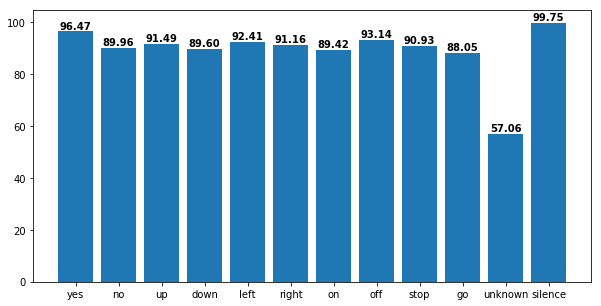

89.1191411591


In [26]:
class_acc = []
for i in range(12):
    idx = np.where(np.argmax(val_data[1], 1)==i)[0]
    preds = np.argmax(val_predictions[idx], 1)
    class_acc.append((100*np.sum(np.argmax(val_data[1][idx], 1) == preds))/idx.shape[0])

label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
plt.figure(figsize=(10,5))
plt.bar(np.arange(12), class_acc)
plt.xticks(np.arange(12), label_list)
for i, v in enumerate(class_acc):
    plt.text(i, v+1, str('{0:.2f}'.format(v)), color='black', fontweight='bold', ha='center')
plt.show()
print(np.mean(class_acc))

### Test Set Prediction

In [6]:
def testData():
    
    arr_size = len(glob.glob('./Data/test/audio/*.wav'))
    x_test = np.zeros((arr_size, 128, 80, 1))
    
    x_file = []
    for idx, file_ in enumerate(glob.glob('./Data/test/audio/*.wav')):
        X, sr = sf.read(file_)
        X, _ = librosa.effects.trim(X)
        
        # For smaller length - equal padding on both sides
        if len(X)<80*200:
            len_req = 80*200-len(X)
            X = np.concatenate((np.zeros((len_req//2)), X, np.zeros((len_req - (len_req//2)))))
        # For bigger lengths - use the middle section
        start_ = (len(X) - (80*200))//2
        X = X[start_:start_+80*200-1]

        file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sr, n_mels=128,
                                                                          hop_length=200), ref=np.max)

        x_test[idx] = file_feature.reshape((128, 80, 1))
        x_file.append(file_[file_.rfind('/')+1:])
        if idx%5000==0:
            print(idx, file_)
    return [x_test, x_file]

In [ ]:
test_data = testData()

0 ./Data/test/audio/clip_269d5f90a.wav


KeyboardInterrupt: 

In [4]:
import h5py
test_data = []
h5f = h5py.File('test.h5','r')
test_data.append(h5f['input_arr'][:])
h5f.close()
test_data.append(pickle.load(open('test_filePaths', 'rb')))

In [5]:
preds = model.predict_proba(test_data[0])

158538/158538 [==============================] - 59s    


In [24]:
predictions = pd.DataFrame(preds, index=test_data[1])

In [31]:
predictions['Prob'] = predictions.max(axis=1)

In [34]:
predictions['Label'] = predictions.idxmax(axis=1)

In [81]:
predictions[predictions['Prob']<0.3]

,0,1,2,3,4,5,6,7,8,9,10,11,Prob,Label
clip_b8bdf53a8.wav,0.023104,0.079802,0.082453,0.088043,0.072363,0.067047,0.160731,0.098920,0.051395,0.075429,0.195858,4.854761e-03,0.195858,10
clip_3aad3bab7.wav,0.052533,0.085712,0.086898,0.087579,0.079293,0.069072,0.080613,0.078017,0.075898,0.094352,0.138799,7.123411e-02,0.138799,10
clip_8230b73d7.wav,0.032497,0.081014,0.050549,0.178643,0.048551,0.056005,0.119108,0.053371,0.072826,0.097243,0.202308,7.884254e-03,0.202308,10
clip_a593926cb.wav,0.047665,0.076538,0.087617,0.106517,0.069932,0.072102,0.081065,0.074717,0.088187,0.100329,0.133731,6.159887e-02,0.133731,10
clip_2588b8608.wav,0.031647,0.098986,0.065656,0.111057,0.061622,0.071577,0.134457,0.073168,0.099421,0.072613,0.173602,6.193011e-03,0.173602,10
clip_1e37dcdf6.wav,0.050155,0.073735,0.100912,0.088548,0.069572,0.072446,0.083613,0.088862,0.071774,0.091439,0.120939,8.800346e-02,0.120939,10
clip_fa16f4bbc.wav,0.000042,0.038390,0.122544,0.011224,0.001345,0.003823,0.213725,0.169462,0.009839,0.215805,0.213801,2.313216e-08,0.215805,9
clip_9e9a32425.wav,0.069686,0.087099,0.099603,0.081969,0.091542,0.077416,0.075119,0.084588,0.088204,0.081302,0.102400,6.107216e-02,0.102400,10
clip_ef8944688.wav,0.044377,0.069233,0.102120,0.091014,0.060815,0.071408,0.087684,0.091724,0.066624,0.099096,0.122822,9.308078e-02,0.122822,10
clip_a7412b47e.wav,0.017437,0.076864,0.101721,0.054846,0.053223,0.148908,0.112796,0.043530,0.018662,0.093011,0.276010,2.991912e-03,0.276010,10


In [1]:
import IPython.display as ipd

In [84]:
name = 'f6a38d929'
ipd.Audio('./Data/test/audio/clip_'+name+'.wav')

1/1 [==============================] - 0s
[[ 0.00738793  0.09018162  0.02625699  0.17185529  0.01853542  0.02532775
   0.24029146  0.06284428  0.03267072  0.05935129  0.26461193  0.00068524]]
10


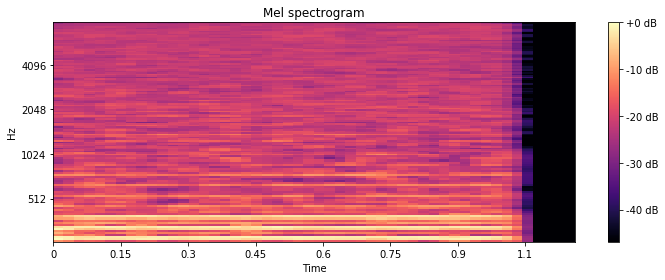

In [87]:
X, sr = sf.read('./Data/test/audio/clip_'+name+'.wav')
X, _ = librosa.effects.trim(X)
if len(X)<50*370:
        X = np.concatenate((X, np.zeros((50*370-len(X)-1))))
X = X[:50*370-1]
S = librosa.power_to_db(
    librosa.feature.melspectrogram(X, sr, n_mels=128, hop_length=370), ref=np.max)
# S = cv2.resize(S, (50, 128))
tmp_pred = model.predict_proba(S.reshape((1, 128, 50, 1)))
print(tmp_pred)
print(np.argmax(tmp_pred))
plt.figure(figsize=(10, 4))
librosa.display.specshow(S, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

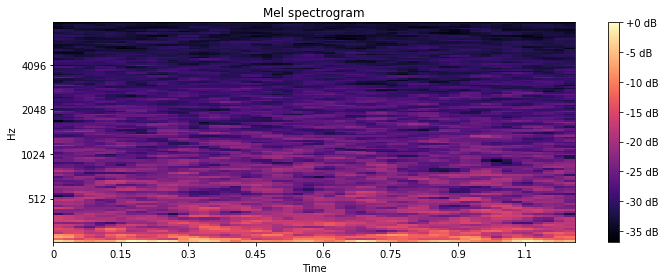

In [49]:
X, sr = sf.read('./Data/train/audio/_background_noise_/pink_noise.wav')
if len(X)<50*370:
        X = np.concatenate((X, np.zeros((50*370-len(X)-1))))
X = X[:50*370-1]
S = librosa.power_to_db(
    librosa.feature.melspectrogram(X, sr, n_mels=128, hop_length=370), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [64]:
submission = pd.read_csv('./Data/sample_submission.csv')
label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']

In [66]:
preds = [label_list[i] for i in preds]

In [68]:
for idx, val in enumerate(submission['fname']):
    submission.loc[idx, 'label'] = preds[test_data[1].index(val)]
    if idx%5000==0:
        print(idx)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000


In [69]:
submission.to_csv('./Submissions/Sub 2 - Val - 0.8894.csv', index=False)

In [80]:
submission[submission['label']=='unknown']

,fname,label
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,unknown
4,clip_0001d1559.wav,unknown
5,clip_0002256ed.wav,unknown
7,clip_0002d9b83.wav,unknown
9,clip_0003c7122.wav,unknown
11,clip_00049951d.wav,unknown
16,clip_0006f7b8b.wav,unknown
19,clip_00094eb22.wav,unknown


In [6]:
import IPython.display as ipd

In [7]:
ipd.Audio('./Data/test/audio/clip_ffe141cf1.wav')